In [1]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


You are using pip version 10.0.1, however version 21.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


You are using pip version 10.0.1, however version 21.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


You are using pip version 10.0.1, however version 21.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [4]:
pip install pandoc

Note: you may need to restart the kernel to use updated packages.


You are using pip version 10.0.1, however version 21.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import pandoc

In [2]:
os.getcwd()

'C:\\Users\\johnk'

Here we load in our combine data, as we can see we have information on players in the combine dating from 2001, along with certain combine data. Note thatc certain metrics have not been included until later combines, explaining the NaN entries

1) We want to add a column to combine data, called "draft position" for ease of use
2) We want to cross-reference the players in combine data with those who were not drafted
3) We want to put draft position in "Buckets" (top 5 picks = "1", lottery (5-14) = "2", late first round = "3", second round = "4", Not Drafted = "5"
4) Once we do this, we can play with the buckets as we go to see what really works best (possible issue: size of buckets differ, you have more players in the second round of the draft than the top 5 picks so any predicting model might just pick the second round for accuracy purposes)
5) Multiclass SVM (on a certain number of features - some of the features are pretty correlated (Height without shoes, height with shoes) so we choose which ones to ignore and which to include
6) Evaluate accuracy on val set, change # of buckets or predictors accordingly
7) Try other methods (neural net but probably not nearly enough data) such as logistic regression or a MultiNB classifier

### Data Cleaning

Step 2: make sure the values for year are integers, along with draft positions

In [3]:
combine = pd.read_csv("C:\\Users\\johnk\combine_fix.csv")

In [4]:
combine

,yearCombine,idPlayer,nameFirst,nameLast,namePlayer,slugPosition,heightWOShoesInches,heightWOShoes,weightLBS,wingspanInches,...,setOffDribBreakLeftCollegePct,setOffDribTopKeyCollegeMade,setOffDribTopKeyCollegeAttempted,setOffDribTopKeyCollegePct,setOffDribBreakRightCollegeMade,setOffDribBreakRightCollegeAttempted,setOffDribBreakRightCollegePct,Unnamed: 116,Unnamed: 117,draftPosition
0,2001,2124,Malik,Allen,Malik Allen,PF-C,80.25,6' 8.25'',271.0,86.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2001,12019,Harold,Arceneaux,Harold Arceneaux,SG-SF,76.50,6' 4.5'',219.0,80.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2001,12020,Lamont,Barnes,Lamont Barnes,PF-C,80.50,6' 8.5'',235.5,87.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2001,12131,Mario,Bland,Mario Bland,PF,77.50,6' 5.5'',287.0,84.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2001,2056,Primoz,Brezec,Primoz Brezec,C,84.75,7' 0.75'',243.0,86.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390,2021,1630214,Xavier,Tillman Sr.,Xavier Tillman Sr.,PF-C,79.50,6'7.50'',266.5,86.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1391,2021,1629700,Kaleb,Wesson,Kaleb Wesson,C,81.25,6'9.25'',252.6,87.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1392,2021,1630232,Kahlil,Whitney,Kahlil Whitney,SF,77.50,6'5.50'',205.0,84.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1393,2021,1630216,Cassius,Winston,Cassius Winston,PG,72.50,6'0.50'',196.0,78.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53


In [5]:
#Removes NaN values, adds empty strings for positions

combine["slugPosition"] = combine["slugPosition"].fillna('')
for position in combine["slugPosition"]:
#Replaces the issue where we have positions defined as "PF-C" and just takes the first postion    
    if len(position) > 2:
        new_position = position[0:2]
        combine["slugPosition"]=combine["slugPosition"].replace(position,new_position,regex=True)

In [6]:
from collections import defaultdict
from itertools import count
from functools import partial

In [7]:
#Code to turn the position into an integer ranged 1-5
labels = ["PG","SG","SF","PF","C"]
label_to_number = defaultdict(partial(next, count(1)))
[(label_to_number[label], label) for label in labels]

[(1, 'PG'), (2, 'SG'), (3, 'SF'), (4, 'PF'), (5, 'C')]

ONLY RUN THESE 2 BLOCKS IN THE CASE YOU WANT TO GROUP POSITIONS UNDER THE CATEGORIES "GUARDS","FORWARDS","CENTER"

In [9]:
basket_labels = ["Guard","Forward","Center"]
for position in combine["slugPosition"]:
    if position == labels[0] or position == labels[1]:
        combine["slugPosition"]=combine["slugPosition"].replace(position,basket_labels[0],regex=True)
    elif position == labels[2] or position == labels[3]:
        combine["slugPosition"]=combine["slugPosition"].replace(position,basket_labels[1],regex=True)
    elif position == labels[4]:
        combine["slugPosition"]=combine["slugPosition"].replace(position,basket_labels[2],regex=True)

In [11]:
label_to_number = defaultdict(partial(next, count(1)))
[(label_to_number[label], label) for label in basket_labels]

[(1, 'Guard'), (2, 'Forward'), (3, 'Center')]

READ ABOVE MARKDOWN --------- OTHERWISE IGNORE AND KEEP GOING -> YOU WILL NEED TO MODIFY THE CODE BELOW IN THE CASE OF BASKET LABELS BEING USED 

In [8]:
for i in range(5):
    combine["slugPosition"]=combine["slugPosition"].replace(labels[i],label_to_number[labels[i]])
combine

,yearCombine,idPlayer,nameFirst,nameLast,namePlayer,slugPosition,heightWOShoesInches,heightWOShoes,weightLBS,wingspanInches,...,setOffDribBreakLeftCollegePct,setOffDribTopKeyCollegeMade,setOffDribTopKeyCollegeAttempted,setOffDribTopKeyCollegePct,setOffDribBreakRightCollegeMade,setOffDribBreakRightCollegeAttempted,setOffDribBreakRightCollegePct,Unnamed: 116,Unnamed: 117,draftPosition
0,2001,2124,Malik,Allen,Malik Allen,4,80.25,6' 8.25'',271.0,86.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2001,12019,Harold,Arceneaux,Harold Arceneaux,2,76.50,6' 4.5'',219.0,80.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2001,12020,Lamont,Barnes,Lamont Barnes,4,80.50,6' 8.5'',235.5,87.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2001,12131,Mario,Bland,Mario Bland,4,77.50,6' 5.5'',287.0,84.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2001,2056,Primoz,Brezec,Primoz Brezec,5,84.75,7' 0.75'',243.0,86.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390,2021,1630214,Xavier,Tillman Sr.,Xavier Tillman Sr.,4,79.50,6'7.50'',266.5,86.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1391,2021,1629700,Kaleb,Wesson,Kaleb Wesson,5,81.25,6'9.25'',252.6,87.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1392,2021,1630232,Kahlil,Whitney,Kahlil Whitney,3,77.50,6'5.50'',205.0,84.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1393,2021,1630216,Cassius,Winston,Cassius Winston,1,72.50,6'0.50'',196.0,78.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53


In [9]:
for position in combine["slugPosition"]:
    if isinstance(position,str):
        new_position = "C"
        combine["slugPosition"]=combine["slugPosition"].replace(position,new_position,regex=True)

for position in combine["slugPosition"]:
    print(position)

4
2
4
4
5
5
1
2
1
3
1
4
1
4
3
1
3
3
3
1
2
1
4
2
2
2
1
2
2
4
2
3
4
2
4
3
1
4
C
2
4
4
5
4
4
3
2
1
2
2
4
1
3
1
1
1
2
5
4
3
4
4
2
1
4
5
2
2
3
2
1
5
4
4
1
4
3
1
3
3
5
4
4
C
4
1
5
3
5
5
2
4
C
C
4
2
1
1
3
4
2
4
5
5
2
C
4
3
3
1
5
5
3
2
3
1
C
2
3
4
4
C
1
1
4
3
2
1
1
4
4
3
1
3
4
1
3
5
1
3
C
4
4
4
4
1
3
3
4
3
4
5
2
1
4
5
3
3
1
5
2
2
3
1
4
4
4
4
4
4
2
1
3
1
4
2
1
4
1
3
4
4
5
C
2
5
1
C
C
1
C
1
3
4
2
4
3
2
2
4
4
1
1
2
4
3
2
4
3
2
4
4
3
3
4
4
1
2
1
4
1
1
4
3
3
4
3
3
3
1
3
2
4
4
1
4
2
4
4
4
2
C
2
3
2
2
4
1
1
2
1
2
C
1
1
4
4
3
4
C
4
4
3
3
2
3
C
2
C
2
1
3
C
4
5
4
C
4
4
4
3
1
4
2
5
4
1
1
2
3
4
4
C
4
1
2
4
3
4
1
C
3
1
2
2
1
4
5
2
3
1
4
1
5
1
5
2
3
3
3
C
1
5
2
2
1
3
C
3
1
1
4
4
4
2
C
3
4
4
1
3
4
1
4
3
3
4
1
1
4
2
1
2
C
4
3
4
2
2
1
1
5
C
4
2
1
4
2
3
2
2
2
4
C
1
4
2
1
4
1
2
3
4
1
2
C
4
4
2
C
3
2
3
C
1
1
5
1
4
1
4
1
2
1
2
C
C
4
4
4
3
1
4
3
C
3
3
1
2
C
3
1
C
3
C
1
2
4
4
1
2
4
4
2
4
4
1
4
2
3
1
4
3
3
1
1
2
5
4
2
C
4
1
3
3
4
4
4
3
4
1
3
4
2
3
4
2
4
2
4
2
C
4
3
4
1
3
2
2
4
3
2
1
1
2
4
1
1
2
4
3
3
4
3
4
4
3
1
4
3


In [10]:
for i in range(5):
    combine["slugPosition"]=combine["slugPosition"].replace(labels[i],label_to_number[labels[i]])
combine

,yearCombine,idPlayer,nameFirst,nameLast,namePlayer,slugPosition,heightWOShoesInches,heightWOShoes,weightLBS,wingspanInches,...,setOffDribBreakLeftCollegePct,setOffDribTopKeyCollegeMade,setOffDribTopKeyCollegeAttempted,setOffDribTopKeyCollegePct,setOffDribBreakRightCollegeMade,setOffDribBreakRightCollegeAttempted,setOffDribBreakRightCollegePct,Unnamed: 116,Unnamed: 117,draftPosition
0,2001,2124,Malik,Allen,Malik Allen,4,80.25,6' 8.25'',271.0,86.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2001,12019,Harold,Arceneaux,Harold Arceneaux,2,76.50,6' 4.5'',219.0,80.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2001,12020,Lamont,Barnes,Lamont Barnes,4,80.50,6' 8.5'',235.5,87.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2001,12131,Mario,Bland,Mario Bland,4,77.50,6' 5.5'',287.0,84.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2001,2056,Primoz,Brezec,Primoz Brezec,5,84.75,7' 0.75'',243.0,86.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390,2021,1630214,Xavier,Tillman Sr.,Xavier Tillman Sr.,4,79.50,6'7.50'',266.5,86.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1391,2021,1629700,Kaleb,Wesson,Kaleb Wesson,5,81.25,6'9.25'',252.6,87.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1392,2021,1630232,Kahlil,Whitney,Kahlil Whitney,3,77.50,6'5.50'',205.0,84.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1393,2021,1630216,Cassius,Winston,Cassius Winston,1,72.50,6'0.50'',196.0,78.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53


Here we had to handle an edge case when converting positions from strings to integers. This is the reason for the somewhat duplicated code

In [11]:
count = 0
for position in combine["draftPosition"]:
    if position == 0:
        count += 1
print(count)

586


In [14]:
new_combine = combine.dropna(subset=["timeLaneAgility","verticalLeapMaxInches","wingspanInches","heightWOShoesInches","slugPosition","weightLBS","repsBenchPress135"])
filter_combine= new_combine[["namePlayer","slugPosition","timeLaneAgility","verticalLeapMaxInches","wingspanInches","heightWOShoesInches","weightLBS","repsBenchPress135","draftPosition"]]
filter_combine

,namePlayer,slugPosition,timeLaneAgility,verticalLeapMaxInches,wingspanInches,heightWOShoesInches,weightLBS,repsBenchPress135,draftPosition
0,Malik Allen,4,11.83,29.0,86.50,80.25,271.0,13.0,0
1,Harold Arceneaux,2,13.80,29.0,80.50,76.50,219.0,0.0,0
2,Lamont Barnes,4,12.30,29.5,87.50,80.50,235.5,10.0,0
3,Mario Bland,4,13.04,31.0,84.00,77.50,287.0,15.0,0
6,Speedy Claxton,1,10.48,42.5,72.00,70.50,166.0,6.0,20
...,...,...,...,...,...,...,...,...,...
1340,Simisola Shittu,4,11.85,35.5,85.25,80.50,227.2,11.0,0
1343,Tremont Waters,1,10.76,40.5,74.25,69.50,172.4,5.0,51
1346,Kris Wilkes,3,10.39,35.0,82.75,78.25,208.8,4.0,0
1347,Grant Williams,4,10.83,31.5,81.75,77.75,240.2,20.0,22


Here we filtered data based on 7 statistics from the combine: Time Lane Agility, Vertical Leap, Wing Span, Height without Shoes, Weight, and Bench Press reps at 135 pounds. We include player name data, position, and draft position

# Running SVM Naively

In [21]:
pip install sklearn

  Running setup.py bdist_wheel for sklearn: started
  Running setup.py bdist_wheel for sklearn: finished with status 'done'
  Stored in directory: C:\Users\johnk\AppData\Local\pip\Cache\wheels\76\03\bb\589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


You are using pip version 10.0.1, however version 21.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [15]:
import sklearn.metrics as metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [16]:
train, test = train_test_split(filter_combine, test_size=0.15)

train_y = train["draftPosition"]
test_y = test["draftPosition"]

train_x= train.drop(columns=["namePlayer","draftPosition"])

test = test.drop(columns = ["namePlayer","draftPosition"])

In [17]:
train_x = train_x.to_numpy()
test = test.to_numpy()

In [18]:
clf = SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(train_x, train_y)

#Predict the response for test dataset
y_pred = clf.predict(test)

In [19]:
print("Accuracy:", metrics.accuracy_score(test_y, y_pred))

Accuracy: 0.5


In [20]:
print(classification_report(test_y,y_pred))

              precision    recall  f1-score   support

           0       0.51      0.98      0.67        81
           4       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         2
          21       0.00      0.00      0.00         2
          22       0.00      0.00      0.00         1
          23       0.00      0.00      0.00         1
          24       0.00    

C:\Users\johnk\.julia\conda\3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\johnk\.julia\conda\3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\johnk\.julia\conda\3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\johnk\.julia\conda\3\lib\site-packages\

Obviously the SVM works terribly when trying to predict 60 different classes, and it picks everything as "Undrafted" which is by far the most common label. Now, we're going to try and explore what happens using different labels -> first, we will try to classify drafted vs undrafted. Next, we will try to classify 1st Round Draft Picks, 2nd Round Draft Picks, and Undrafted players. Based on the success we will try to explore more granular examples.

# Classifying Drafted vs Undrafted

In [21]:
filter_combine

,namePlayer,slugPosition,timeLaneAgility,verticalLeapMaxInches,wingspanInches,heightWOShoesInches,weightLBS,repsBenchPress135,draftPosition
0,Malik Allen,4,11.83,29.0,86.50,80.25,271.0,13.0,0
1,Harold Arceneaux,2,13.80,29.0,80.50,76.50,219.0,0.0,0
2,Lamont Barnes,4,12.30,29.5,87.50,80.50,235.5,10.0,0
3,Mario Bland,4,13.04,31.0,84.00,77.50,287.0,15.0,0
6,Speedy Claxton,1,10.48,42.5,72.00,70.50,166.0,6.0,20
...,...,...,...,...,...,...,...,...,...
1340,Simisola Shittu,4,11.85,35.5,85.25,80.50,227.2,11.0,0
1343,Tremont Waters,1,10.76,40.5,74.25,69.50,172.4,5.0,51
1346,Kris Wilkes,3,10.39,35.0,82.75,78.25,208.8,4.0,0
1347,Grant Williams,4,10.83,31.5,81.75,77.75,240.2,20.0,22


In [22]:
draft_undraft = filter_combine

for position in draft_undraft["draftPosition"]:
    if position > 0:
        draft_undraft["draftPosition"]=draft_undraft["draftPosition"].replace(position,1,regex=True)

C:\Users\johnk\.julia\conda\3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [23]:
draft_undraft

,namePlayer,slugPosition,timeLaneAgility,verticalLeapMaxInches,wingspanInches,heightWOShoesInches,weightLBS,repsBenchPress135,draftPosition
0,Malik Allen,4,11.83,29.0,86.50,80.25,271.0,13.0,0
1,Harold Arceneaux,2,13.80,29.0,80.50,76.50,219.0,0.0,0
2,Lamont Barnes,4,12.30,29.5,87.50,80.50,235.5,10.0,0
3,Mario Bland,4,13.04,31.0,84.00,77.50,287.0,15.0,0
6,Speedy Claxton,1,10.48,42.5,72.00,70.50,166.0,6.0,1
...,...,...,...,...,...,...,...,...,...
1340,Simisola Shittu,4,11.85,35.5,85.25,80.50,227.2,11.0,0
1343,Tremont Waters,1,10.76,40.5,74.25,69.50,172.4,5.0,1
1346,Kris Wilkes,3,10.39,35.0,82.75,78.25,208.8,4.0,0
1347,Grant Williams,4,10.83,31.5,81.75,77.75,240.2,20.0,1


In [51]:
train, test = train_test_split(draft_undraft, test_size=0.15)

train_y = train["draftPosition"]
test_y = test["draftPosition"]

train_x= train.drop(columns=["namePlayer","draftPosition", "slugPosition"])

test = test.drop(columns = ["namePlayer","draftPosition", "slugPosition"])

train_x = train_x.to_numpy()
test = test.to_numpy()

In [52]:
clf = SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(train_x, train_y)

#Predict the response for test dataset
y_pred = clf.predict(test)

In [53]:
print("Accuracy:", metrics.accuracy_score(test_y, y_pred))

Accuracy: 0.6139240506329114


In [54]:
print(classification_report(test_y,y_pred))

              precision    recall  f1-score   support

           0       0.58      0.41      0.48        69
           1       0.63      0.78      0.69        89

    accuracy                           0.61       158
   macro avg       0.61      0.59      0.59       158
weighted avg       0.61      0.61      0.60       158



In [55]:
cm = metrics.confusion_matrix(test_y,y_pred)

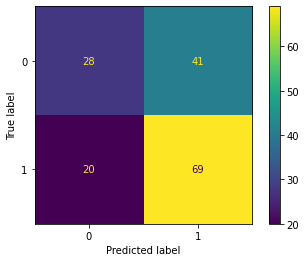

In [56]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

As we see, the false positive "drafted" rate is significantly higher. This is rather unsuprising as there are 58% drafted players in the dataset, so our classifier is likely to predict positive much more often than a false negative, of which happens only 5% of the time!

# Logistic Regression on Draft vs Undraft

In [57]:
from sklearn.linear_model import LogisticRegression

In [58]:
#scaler = preprocessing.StandardScaler().fit(train_x)
#pipe = make_pipeline(StandardScaler(), LogisticRegression())
#pipe.fit(train_x, train_y)
#pred_y = pipe.predict(test)
logReg = LogisticRegression()
logReg.fit(train_x, train_y)
pred_y = logReg.predict(test)
logReg.coef_


array([[-0.78628852,  0.0568575 ,  0.06066673,  0.01816986,  0.0055042 ,
        -0.02690151]])

In [59]:
print("Accuracy:", metrics.accuracy_score(test_y, pred_y))

Accuracy: 0.6329113924050633


In [60]:
print(classification_report(test_y,pred_y))

              precision    recall  f1-score   support

           0       0.61      0.45      0.52        69
           1       0.64      0.78      0.70        89

    accuracy                           0.63       158
   macro avg       0.63      0.61      0.61       158
weighted avg       0.63      0.63      0.62       158



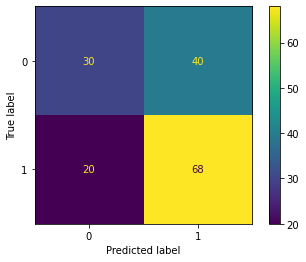

In [45]:
cm = metrics.confusion_matrix(test_y,pred_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [34]:
importance = pipe.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

AttributeError: 'Pipeline' object has no attribute 'coef_'

# 1st Round, 2nd Round, or Undrafted? with SVM

In [35]:
filter_combine= new_combine[["namePlayer","slugPosition","timeLaneAgility","verticalLeapMaxInches","wingspanInches","heightWOShoesInches","weightLBS","repsBenchPress135","draftPosition"]]
filter_combine

,namePlayer,slugPosition,timeLaneAgility,verticalLeapMaxInches,wingspanInches,heightWOShoesInches,weightLBS,repsBenchPress135,draftPosition
0,Malik Allen,4,11.83,29.0,86.50,80.25,271.0,13.0,0
1,Harold Arceneaux,2,13.80,29.0,80.50,76.50,219.0,0.0,0
2,Lamont Barnes,4,12.30,29.5,87.50,80.50,235.5,10.0,0
3,Mario Bland,4,13.04,31.0,84.00,77.50,287.0,15.0,0
6,Speedy Claxton,1,10.48,42.5,72.00,70.50,166.0,6.0,20
...,...,...,...,...,...,...,...,...,...
1340,Simisola Shittu,4,11.85,35.5,85.25,80.50,227.2,11.0,0
1343,Tremont Waters,1,10.76,40.5,74.25,69.50,172.4,5.0,51
1346,Kris Wilkes,3,10.39,35.0,82.75,78.25,208.8,4.0,0
1347,Grant Williams,4,10.83,31.5,81.75,77.75,240.2,20.0,22


In [37]:
three_class = filter_combine
three_class.reset_index(drop=True,inplace=True)
three_class

,namePlayer,slugPosition,timeLaneAgility,verticalLeapMaxInches,wingspanInches,heightWOShoesInches,weightLBS,repsBenchPress135,draftPosition
0,Malik Allen,4,11.83,29.0,86.50,80.25,271.0,13.0,0
1,Harold Arceneaux,2,13.80,29.0,80.50,76.50,219.0,0.0,0
2,Lamont Barnes,4,12.30,29.5,87.50,80.50,235.5,10.0,0
3,Mario Bland,4,13.04,31.0,84.00,77.50,287.0,15.0,0
4,Speedy Claxton,1,10.48,42.5,72.00,70.50,166.0,6.0,20
...,...,...,...,...,...,...,...,...,...
1042,Simisola Shittu,4,11.85,35.5,85.25,80.50,227.2,11.0,0
1043,Tremont Waters,1,10.76,40.5,74.25,69.50,172.4,5.0,51
1044,Kris Wilkes,3,10.39,35.0,82.75,78.25,208.8,4.0,0
1045,Grant Williams,4,10.83,31.5,81.75,77.75,240.2,20.0,22


In [38]:

for row,position in enumerate(three_class["draftPosition"]):
    if position >0 and position <31:
        three_class.loc[row,"draftPosition"] = 1
for row,position in enumerate(three_class["draftPosition"]):
    if position>30:
        three_class.loc[row,"draftPosition"] = 2
three_class

C:\Users\johnk\.julia\conda\3\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,namePlayer,slugPosition,timeLaneAgility,verticalLeapMaxInches,wingspanInches,heightWOShoesInches,weightLBS,repsBenchPress135,draftPosition
0,Malik Allen,4,11.83,29.0,86.50,80.25,271.0,13.0,0
1,Harold Arceneaux,2,13.80,29.0,80.50,76.50,219.0,0.0,0
2,Lamont Barnes,4,12.30,29.5,87.50,80.50,235.5,10.0,0
3,Mario Bland,4,13.04,31.0,84.00,77.50,287.0,15.0,0
4,Speedy Claxton,1,10.48,42.5,72.00,70.50,166.0,6.0,1
...,...,...,...,...,...,...,...,...,...
1042,Simisola Shittu,4,11.85,35.5,85.25,80.50,227.2,11.0,0
1043,Tremont Waters,1,10.76,40.5,74.25,69.50,172.4,5.0,2
1044,Kris Wilkes,3,10.39,35.0,82.75,78.25,208.8,4.0,0
1045,Grant Williams,4,10.83,31.5,81.75,77.75,240.2,20.0,1


In [39]:
counter=0
for position in three_class["draftPosition"]:
    if position == 2:
        counter += 1
print(counter)

283


In [40]:
train, test = train_test_split(three_class, test_size=0.15)

train_y = train["draftPosition"]
test_y = test["draftPosition"]

train_x= train.drop(columns=["namePlayer","draftPosition"])

test = test.drop(columns = ["namePlayer","draftPosition"])

train_x = train_x.to_numpy()
test = test.to_numpy()

In [41]:
clf = SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(train_x, train_y)

#Predict the response for test dataset
y_pred = clf.predict(test)

In [42]:
print("Accuracy:", metrics.accuracy_score(test_y, y_pred))

Accuracy: 0.45569620253164556


In [43]:
print(classification_report(test_y,y_pred))

              precision    recall  f1-score   support

           0       0.50      0.80      0.61        69
           1       0.36      0.36      0.36        47
           2       0.00      0.00      0.00        42

    accuracy                           0.46       158
   macro avg       0.29      0.39      0.32       158
weighted avg       0.32      0.46      0.37       158



C:\Users\johnk\.julia\conda\3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\johnk\.julia\conda\3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\johnk\.julia\conda\3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


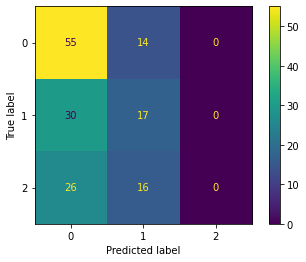

In [44]:
cm = metrics.confusion_matrix(test_y,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

1st Round, 2nd Round, or Undrafted? with Logistic

In [45]:
scaler = preprocessing.StandardScaler().fit(train_x)
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(train_x, train_y)
pred_y = pipe.predict(test)

In [46]:
print("Accuracy:", metrics.accuracy_score(test_y, pred_y))

Accuracy: 0.4430379746835443


In [47]:
print(classification_report(test_y,pred_y))

              precision    recall  f1-score   support

           0       0.46      0.75      0.57        69
           1       0.40      0.34      0.37        47
           2       0.40      0.05      0.09        42

    accuracy                           0.44       158
   macro avg       0.42      0.38      0.34       158
weighted avg       0.43      0.44      0.38       158



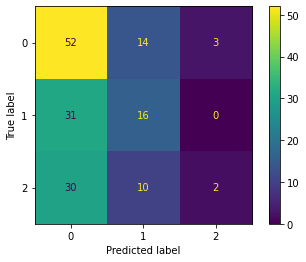

In [48]:
cm = metrics.confusion_matrix(test_y,pred_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Exploratory Data Analysis

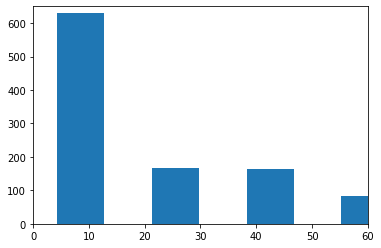

In [49]:
# matplot as plt
# data from filter_combine, draftPosition
# x - draft position, y - amount of people drafted in that position

filter_combine= new_combine[["namePlayer","slugPosition","timeLaneAgility","verticalLeapMaxInches","wingspanInches","heightWOShoesInches","weightLBS","repsBenchPress135","draftPosition"]]

draft_positions = filter_combine.loc[:,"draftPosition"]

plt.hist(draft_positions, rwidth = 0.5)
plt.axis([0,60,0,650])

plt.show()